In [163]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool, cv
import seaborn as sns
data = pd.read_csv('/Users/user/Desktop/UCL_CS_Masters/Dissertation/data.xlsx')


In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
pip install numpy==1.20.0


In [ ]:
# calculated adjusted R^2
def adj_r2(X_actual_test, y_actual_test, predictions):
    return 1-(1-r2_score(y_actual_test, predictions))*((len(X_actual_test)-1)/(len(X_actual_test)-len(X_actual_test.columns)-1))

In [3]:
X = data.drop(columns = ['LGD'], axis=1)
y = data['LGD']

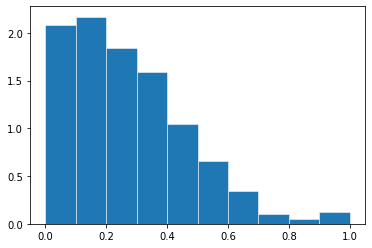

In [4]:
# the distribution that is used for stratification
n, bins, _ = plt.hist(data['LGD'], bins=10, density=True, alpha = 1, linewidth=0.5, edgecolor='white')

In [5]:
# group so when we divide into train and test, it's done in stratified fashion
import numpy as np
data['stratification'] = 0
for index in range(len(bins)):
    data['stratification'] = np.where(data.LGD > bins[index], bins[index], data.stratification)

In [6]:

from sklearn.model_selection import train_test_split
X = data.drop(columns = ['LGD','legal_costs'], axis=1)
y = data['LGD']
# stratified fashion
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0, stratify = data['stratification'] )
# X_train1, X_val, y_train1, y_val  = train_test_split(X_train1, y_train1, test_size=0.25, random_state=1, stratify = X_train1['stratification'] ) # 0.25 x 0.8 = 0.2
# dropping the columns of 'stratification'
X_train1 = X_train1.drop(columns = ['stratification'], axis=1)
X_test1 = X_test1.drop(columns = ['stratification'], axis=1)
# X_val = X_val.drop(columns = ['stratification'], axis=1)

# creating a catboost pool to be used in the models 
# not stratified fashion
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0)
# categorical features of the model
cat_features = ['orign_qtr', 'flag_fthb', 'occpy_sts', 'channel', 'st', 'prop_type', 'loan_purpose']
# Creating Pool
train_dataset = Pool(data = X_train1, label=y_train1, cat_features=cat_features)
test_dataset = Pool(data = X_test1, label=y_test1, cat_features=cat_features)

### Gridsearch for GBM regressor (used over all the models)

In [188]:
# gridsearch for hyperparams and quantization settings 

from sklearn.model_selection import train_test_split
X = data.drop(columns = ['LGD','legal_costs'], axis=1)
y = data['LGD']
# stratified fashion
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0, stratify = data['stratification'] )
# X_train1, X_val, y_train1, y_val  = train_test_split(X_train1, y_train1, test_size=0.25, random_state=1, stratify = X_train1['stratification'] ) # 0.25 x 0.8 = 0.2
# dropping the columns of 'stratification'
X_train1 = X_train1.drop(columns = ['stratification'], axis=1)
X_test1 = X_test1.drop(columns = ['stratification'], axis=1)
# X_val = X_val.drop(columns = ['stratification'], axis=1)

# not stratified fashion
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0)
# categorical features of the model
cat_features = ['orign_qtr', 'flag_fthb', 'occpy_sts', 'channel', 'st', 'prop_type', 'loan_purpose']
# Creating Pool
train_dataset = Pool(data = X_train1, label=y_train1, cat_features=cat_features)
test_dataset = Pool(data = X_test1, label=y_test1, cat_features=cat_features)
# eval_dataset = Pool(data = X_val, label=y_val, cat_features = cat_features )



grid = {'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.02, 0.1, 0.2],
        'depth': [2, 3, 4, 5,6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9], 
        'bootstrap_type':['Bayesian'], 
        'bagging_temperature':[0], 
#         'max_leaves': [3,5,7,10,15,20],
        'score_function':['L2', 'Cosine'], 
        'early_stopping_rounds': [50,100, 200, 300, 400, 500], 
       'border_count': [200, 300, 350, 400], 
        'feature_border_type': ['MinEntropy'], 
        'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=50:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Borders:CtrBorderCount=10:CtrBorderType=Uniform:TargetBorderCount=50:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=60:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=10:CtrBorderType=Uniform:Prior=0/1']]}

hyper_model_depthwise_ctr = CatBoostRegressor(boosting_type = 'Plain',
                                              bootstrap_type='Bayesian',
                                              logging_level='Silent',
                                              eval_metric='R2',
                                task_type = 'CPU', 
                                # early_stopping_rounds = 1000, 
                                grow_policy = 'Depthwise',
                                # use_best_model = True, 
                                leaf_estimation_method = 'Newton',
                                # use_best_model = True 
                                # iterations = 2000,
                                
                                # train_dir= '/content/drive/My Drive/Model results/gridsearch_05_08_grid',
                                # snapshot_file = '/content/drive/My Drive/Model results/gridsearch_04_08_00/experiment.cbsnapshot'
                                )
hyper_model_depthwise_randomized_search_result_ctr = hyper_model_depthwise_ctr.grid_search(grid,
                                                         cv = 5,
                                                  # boosting_type = 'Ordered',
                                                  # logging_level='Silent',
                                                  # task_type = 'GPU',
                                                   plot=True,
                                                   X=train_dataset,
                                                   verbose = False
#                                                    y=y_train1,

                                                   )

# # Fit model
# hyper_model_depthwise_randomized_search_result.fit(train_dataset, plot= True)
# # Get predictions
# hyper_model_depthwise_randomized_search_result_preds = hyper_model_depthwise_randomized_search_result.predict(test_dataset)


Change of simpleCtr will not affect combinations ctrs.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of 

KeyboardInterrupt: 

In [ ]:
hyper_model_depthwise.fit(train_dataset, plot= True)

### GBM model with depthwise tree structure and hyperparameters after gridsearch

In [41]:
# depthwise model with gridsearched parameters
hyper_model_depthwise_final_params = CatBoostRegressor(boosting_type = 'Plain',
                                                       iterations = 53,
                                          depth=8, 
                                          l2_leaf_reg=1, 
                                          learning_rate=0.1,
                                          score_function='Cosine', 
                                        early_stopping_rounds=50,
                                          bagging_temperature=0,
                                logging_level='Silent',
                                eval_metric='R2',
                                task_type = 'CPU', 
                                # early_stopping_rounds = 1000, 
                                grow_policy = 'Depthwise',
                                # use_best_model = True, 
                                leaf_estimation_method = 'Newton',
                                # use_best_model = True 
                                # iterations = 2000,
                                
                                # train_dir= '/content/drive/My Drive/Model results/gridsearch_05_08_grid',
                                # snapshot_file = '/content/drive/My Drive/Model results/gridsearch_04_08_00/experiment.cbsnapshot'
                                )

hyper_model_depthwise_final_params.fit(train_dataset, plot= True)
hyper_model_depthwise_final_params_preds = hyper_model_depthwise_final_params.predict(test_dataset)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [25]:
# save the model 
hyper_model_depthwise_final_params.save_model(
    'hyper_model_depthwise.json', #path to the model with datetime
    format="json",
    pool=train_dataset  # training dataset that is previously used for training
)

In [43]:
#Training  results without any hyper search with RMSE as the loss function
print('Training: R^2 of the model', r2_score(y_train1, hyper_model_depthwise_final_params.predict(train_dataset)))
print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, hyper_model_depthwise_final_params.predict(train_dataset)))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, hyper_model_depthwise_final_params.predict(train_dataset)))))
print('Training: MSE of the model', mean_squared_error(y_train1, hyper_model_depthwise_final_params.predict(train_dataset)))

Training: R^2 of the model 0.7554275010543012
Training: Adjusted R^2 0.7415683927807116
Training: RMSE of the model 0.09782625400072083
Training: MSE of the model 0.009569975971813548


In [42]:
# Testing results
rmse_hyper_model_depthwise = (np.sqrt(mean_squared_error(y_test1, hyper_model_depthwise_final_params_preds)))
r2_hyper_model_depthwise = r2_score(y_test1, hyper_model_depthwise_final_params_preds)
print('Testing: R^2 of the model', r2_hyper_model_depthwise)
print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, hyper_model_depthwise_final_params_preds))
print('Testing: RMSE of the model', rmse_hyper_model_depthwise)
print('Testing: MSE of the model', mean_squared_error(y_test1, hyper_model_depthwise_final_params_preds))

Testing: R^2 of the model 0.46076613855420157
Testing: Adjusted R^2 0.3837327297762304
Testing: RMSE of the model 0.1431138017761616
Testing: MSE of the model 0.020481560258826473


### GBM regressor with Lossguide growing policy and parameters after gridsearch

In [221]:
# depthwise model with gridsearched parameters
hyper_model_lossguide_final_params = CatBoostRegressor(iterations=600,
    boosting_type = 'Plain',
                                                       bootstrap_type = 'Bayesian',
                                          max_leaves=3, 
                                          l2_leaf_reg=5, 
                                          learning_rate=0.2,
                                          score_function='Cosine', 
                                        early_stopping_rounds=10,
                                          bagging_temperature=0,
                                logging_level='Silent',
                                eval_metric='R2',
                                task_type = 'CPU', 
                                # early_stopping_rounds = 1000, 
                                grow_policy = 'Lossguide',
                                # use_best_model = True, 
                                leaf_estimation_method = 'Newton',
                                # use_best_model = True 
                                # iterations = 2000,
                                
                                # train_dir= '/content/drive/My Drive/Model results/gridsearch_05_08_grid',
                                # snapshot_file = '/content/drive/My Drive/Model results/gridsearch_04_08_00/experiment.cbsnapshot'
                                )

hyper_model_lossguide_final_params.fit(train_dataset, plot= True)
hyper_model_lossguide_final_params_preds = hyper_model_lossguide_final_params.predict(test_dataset)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [40]:
# Training  results without any hyper search with RMSE as the loss function
print('Training: R^2 of the model', r2_score(y_train1, hyper_model_lossguide_final_params.predict(train_dataset)))
print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, hyper_model_lossguide_final_params.predict(train_dataset)))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, hyper_model_lossguide_final_params.predict(train_dataset)))))
print('Training: MSE of the model', mean_squared_error(y_train1, hyper_model_lossguide_final_params.predict(train_dataset)))

Training: R^2 of the model 0.7512767778675637
Training: Adjusted R^2 0.7371824619467258
Training: RMSE of the model 0.09865288284581193
Training: MSE of the model 0.009732391293789494


In [39]:
rmse_hyper_model_lossguide = (np.sqrt(mean_squared_error(y_test1, hyper_model_lossguide_final_params_preds)))
r2_hyper_model_lossguide = r2_score(y_test1, hyper_model_lossguide_final_params_preds)
print('Testing: R^2 of the model', r2_hyper_model_lossguide)
print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, hyper_model_lossguide_final_params_preds))
print('Testing: RMSE of the model', rmse_hyper_model_lossguide)
print('Testing: MSE of the model', mean_squared_error(y_test1, hyper_model_lossguide_final_params_preds))

Testing: R^2 of the model 0.4535967803378431
Testing: Adjusted R^2 0.3755391775289636
Testing: RMSE of the model 0.14406204174357481
Testing: MSE of the model 0.020753871871327496


In [34]:
hyper_model_lossguide_final_params.save_model(
    'hyper_model_lossguide.json', #path to the model with datetime
    format="json",
    pool=train_dataset  # training dataset that is previously used for training
)

### GBM regressor with symmetric tree growing policy and hyperparameters after gridsearch

In [183]:
# symmetric model with gridsearched parameters
hyper_model_symmetric_final_params = CatBoostRegressor(iterations=230,
    boosting_type = 'Ordered',
                                                       bootstrap_type = 'Bayesian',
                                          depth=4, 
                                          l2_leaf_reg=7, 
                                          learning_rate=0.1,
                                          score_function='L2', 
                                        early_stopping_rounds=20,
#                                                        ignored_features = ['cltv'],
                                          bagging_temperature=0,
                                logging_level='Silent',
                                eval_metric='R2',
                                task_type = 'CPU', 
                                # early_stopping_rounds = 1000, 
                                grow_policy = 'SymmetricTree',
                                # use_best_model = True, 
                                leaf_estimation_method = 'Newton',
                                                       border_count = 300,
                                                           one_hot_max_size=0,
                                                           feature_border_type = 'MinEntropy', 
                                                       simple_ctr = ['Borders:TargetBorderType=MinEntropy', 'Borders:TargetBorderCount=20'],
                                                       monotone_constraints = {'orig_upb':-1, 'days_dlq':-1, 'mths_remng':1},
                                # use_best_model = True 
                                # iterations = 2000,
                                
                                # train_dir= '/content/drive/My Drive/Model results/gridsearch_05_08_grid',
                                # snapshot_file = '/content/drive/My Drive/Model results/gridsearch_04_08_00/experiment.cbsnapshot'
                                )

hyper_model_symmetric_final_params.fit(train_dataset, plot= True)
hyper_model_symmetric_final_params_preds = hyper_model_symmetric_final_params.predict(test_dataset)

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Change of simpleCtr will not affect combinations ctrs.


In [184]:
# Training  results without any hyper search with RMSE as the loss function
print('Training: R^2 of the model', r2_score(y_train1, hyper_model_symmetric_final_params.predict(train_dataset)))
print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, hyper_model_symmetric_final_params.predict(train_dataset)))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, hyper_model_symmetric_final_params.predict(train_dataset)))))
print('Training: MSE of the model', mean_squared_error(y_train1, hyper_model_symmetric_final_params.predict(train_dataset)))

Training: R^2 of the model 0.5945933734179816
Training: Adjusted R^2 0.5716203312450006
Training: RMSE of the model 0.12594967023615483
Training: MSE of the model 0.015863319432596147


In [185]:
rmse_hyper_model_symmetric = (np.sqrt(mean_squared_error(y_test1, hyper_model_symmetric_final_params_preds)))
r2_hyper_model_symmetric = r2_score(y_test1, hyper_model_symmetric_final_params_preds)
print('Testing: R^2 of the model', r2_hyper_model_symmetric)
print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, hyper_model_symmetric_final_params_preds))
print('Testing: RMSE of the model', rmse_hyper_model_symmetric)
print('Testing: MSE of the model', mean_squared_error(y_test1, hyper_model_symmetric_final_params_preds))


Testing: R^2 of the model 0.5111122410341788
Testing: Adjusted R^2 0.4412711326104901
Testing: RMSE of the model 0.13626914228925222
Testing: MSE of the model 0.01856927914024847


In [99]:
# save model
hyper_model_symmetric_final_params.save_model(
    'hyper_model_symmetric_ordered_monotone_constraints_higher_r2_best.json', #path to the model with datetime
    format="json",
    pool=train_dataset  # training dataset that is previously used for training
)

In [181]:
rmse_hyper_model_depthwise_ctr = (np.sqrt(mean_squared_error(y_test1, hyper_model_depthwise_final_params_preds_ctr)))
r2_hyper_model_depthwise_ctr = r2_score(y_test1, hyper_model_depthwise_final_params_preds_ctr)
print('Testing: R^2 of the model', r2_hyper_model_depthwise_ctr)
print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, hyper_model_depthwise_final_params_preds_ctr))
print('Testing: RMSE of the model', rmse_hyper_model_depthwise_ctr)
print('Testing: MSE of the model', mean_squared_error(y_test1, hyper_model_depthwise_final_params_preds_ctr))

Testing: R^2 of the model 0.4509147269200593
Testing: Adjusted R^2 0.3724739736229249
Testing: RMSE of the model 0.14441517757136257
Testing: MSE of the model 0.02085574351296818


In [113]:
# matplotlib settings
import matplotlib as mpl
plt.style.use(['seaborn-bright'])
mpl.rcParams['lines.linewidth'] = 2
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({
    "text.usetex": False})

%matplotlib inline

In [14]:
# to be updated for SHAP library to work 
# import os
# os.environ["PATH"] += os.pathsep + '/usr/local/bin/dot'
# os.environ["PATH"]

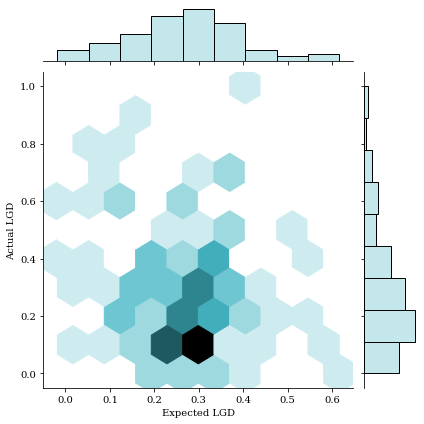

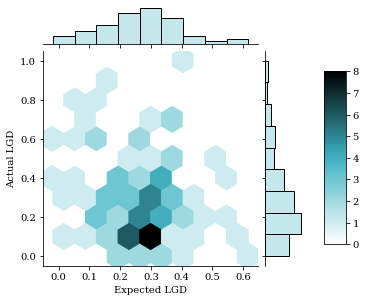

In [218]:
# Results of the best predicting model 
sns.jointplot(x=pd.Series(hyper_model_symmetric_final_params_preds, name ='Expected LGD'), y=y_test1.rename('Actual LGD'), kind="hex", color="powderblue")
hexplot = sns.jointplot(x=pd.Series(hyper_model_symmetric_final_params_preds, name ='Expected LGD'), y=y_test1.rename('Actual LGD'), kind="hex", color="powderblue")
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = hexplot.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/results-dist.png', transparent=True)
plt.show()


### Interpretability

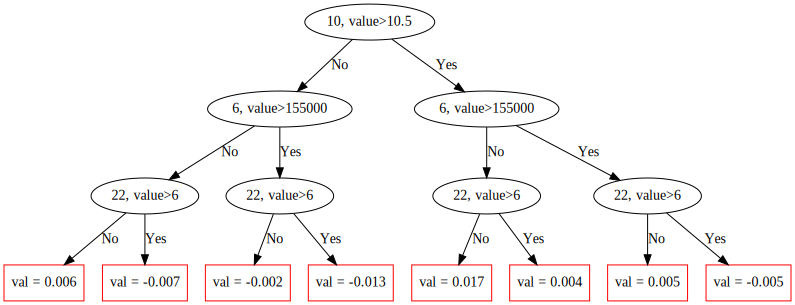

In [18]:
hyper_model_symmetric_final_params.plot_tree(
    tree_idx=0,
    # pool=pool, 
)

In [118]:
#Feature analysis:
import shap

In [121]:
# TreeExplainer (https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.TreeExplainer.html)
explainer = shap.TreeExplainer(hyper_model_symmetric_final_params)
shap_values = explainer(X_test1)

In [131]:
shap_values_train = explainer(X_train1)

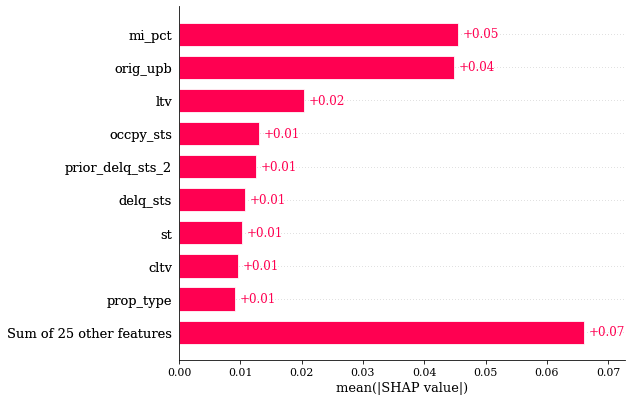

In [225]:
# aggregated across all the test predictions 
import matplotlib.pyplot as pl
shap.plots.bar(shap_values, show=False)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/shap_summary.png', transparent=True, bbox_inches = "tight")

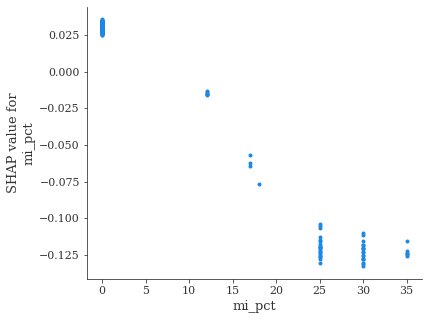

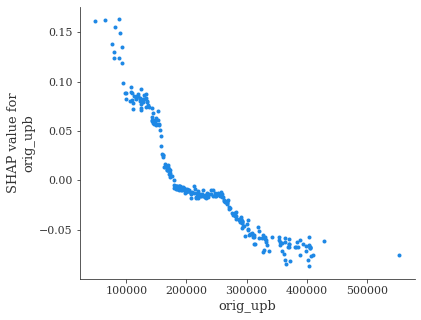

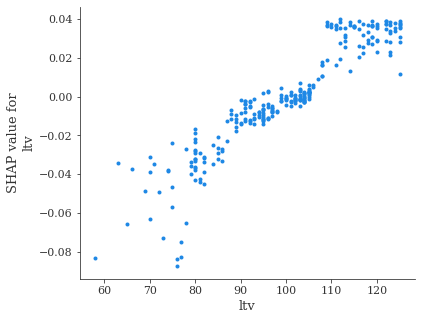

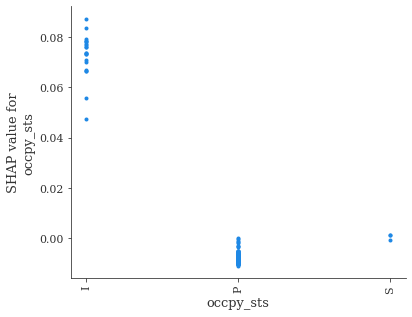

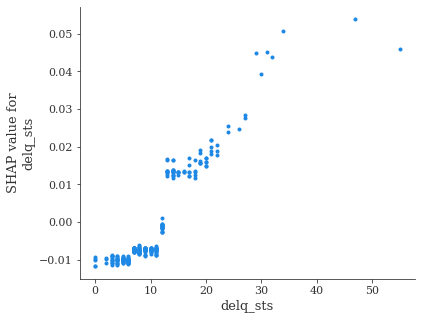

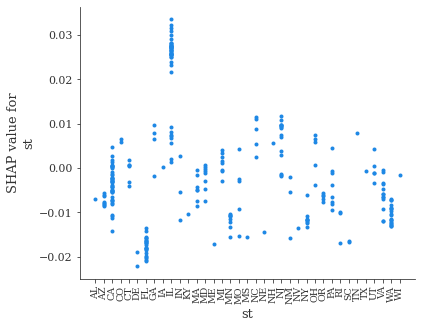

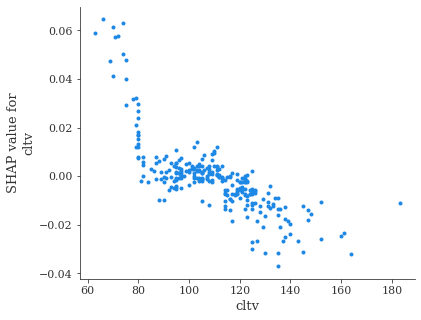

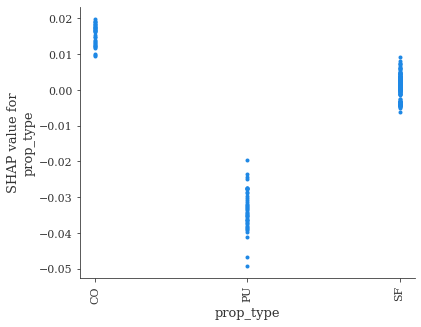

In [234]:
# separate visual for latex 

shap.dependence_plot("mi_pct", shap_values.values, X_test1, interaction_index=None, show=False)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/shap_dependence_mi_pct.png', transparent=True, bbox_inches = "tight")

shap.dependence_plot("orig_upb", shap_values.values, X_test1, interaction_index=None, show=False)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/shap_dependence_orig_upb.png', transparent=True, bbox_inches = "tight")

shap.dependence_plot("ltv", shap_values.values, X_test1, interaction_index=None, show=False)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/shap_dependence_ltv.png', transparent=True, bbox_inches = "tight")

shap.dependence_plot("occpy_sts", shap_values.values, X_test1, interaction_index=None,show=False)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/occpy_sts.png', transparent=True, bbox_inches = "tight")

shap.dependence_plot("delq_sts", shap_values.values, X_test1, interaction_index=None,show=False)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/delq_sts.png', transparent=True, bbox_inches = "tight")

shap.dependence_plot("st", shap_values.values, X_test1, interaction_index=None,show=False)
plt.xticks(fontsize=9.5)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/st.png', transparent=True, bbox_inches = "tight")

shap.dependence_plot("cltv", shap_values.values, X_test1, interaction_index=None,show=False)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/cltv.png', transparent=True, bbox_inches = "tight")

shap.dependence_plot("prop_type", shap_values.values, X_test1, interaction_index=None,show=False)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/prop_type.png', transparent=True, bbox_inches = "tight")



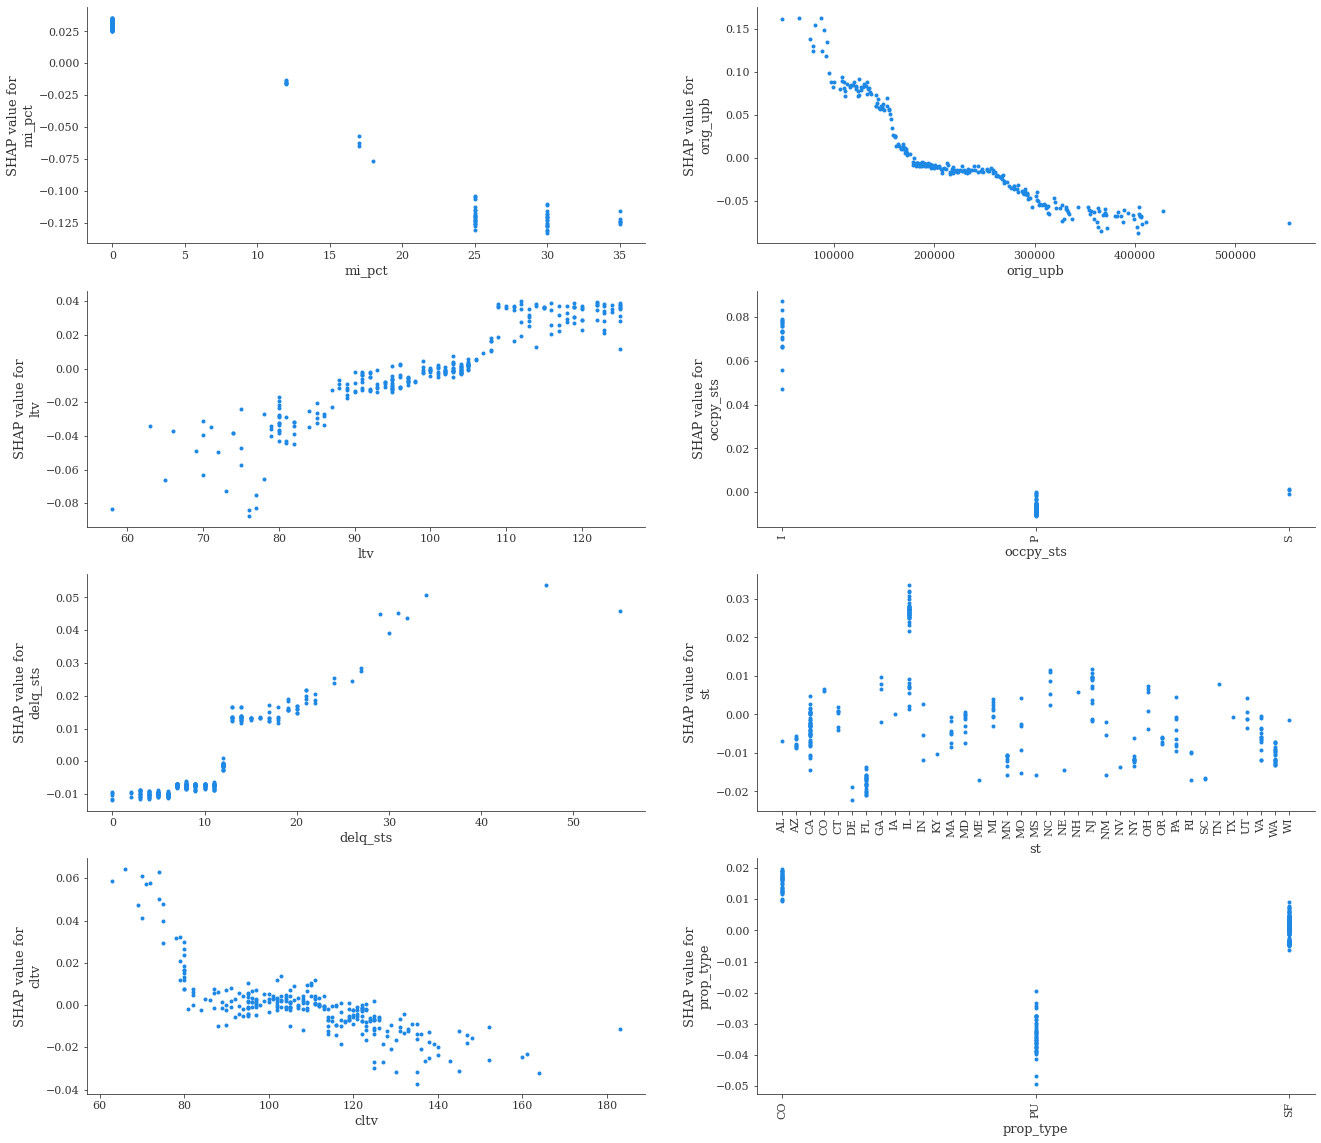

In [203]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(22, 20))
axes = axes.ravel()
shap.dependence_plot("mi_pct", shap_values.values, X_test1, interaction_index=None, ax=axes[0], show=False)
# shap.dependence_plot("orig_upb", shap_values.values, X_test1, interaction_index=None, ax=axes[1], show=False)
# shap.dependence_plot("ltv", shap_values.values, X_test1, interaction_index=None, ax=axes[2], show=False)
# shap.dependence_plot("occpy_sts", shap_values.values, X_test1, interaction_index=None, ax=axes[3],show=False)
# shap.dependence_plot("delq_sts", shap_values.values, X_test1, interaction_index=None, ax=axes[4],show=False)
# shap.dependence_plot("st", shap_values.values, X_test1, interaction_index=None, ax=axes[5],show=False)
# shap.dependence_plot("cltv", shap_values.values, X_test1, interaction_index=None, ax=axes[6],show=False)
# shap.dependence_plot("prop_type", shap_values.values, X_test1, interaction_index=None, ax=axes[7],show=False)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/shap_dependence_mi_pct.png', transparent=True)

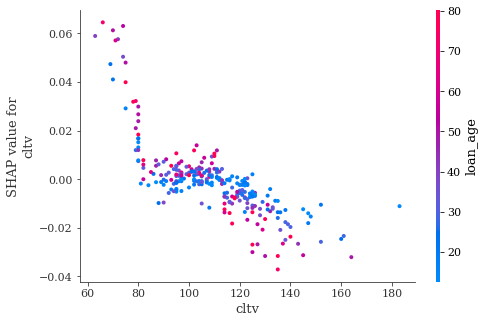

In [236]:
# looking for the explanation of cltv 
shap.dependence_plot("cltv", shap_values.values, X_test1, interaction_index='auto',show=False)
plt.savefig('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/final_artworks/cltv-loanage.png', transparent=True, bbox_inches = "tight")

In [15]:
shap.initjs()
# shap.plots.force(shap_values[0])

### Baseline model

In [67]:
# baseline model (linear regression)


from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# preprocessing
X = data.drop(columns = ['LGD','legal_costs'], axis=1)
y = data['LGD']

X_transform = X.drop(columns=['stratification'], axis=1)
X_transform = pd.get_dummies(X_transform, columns=['orign_qtr', 'flag_fthb', 'occpy_sts', 'channel', 'st', 'prop_type', 'loan_purpose'])


# splitting
X_transform_train1, X_transform_test1, y_transform_train1, y_transform_test1 = train_test_split(X_transform, y, test_size=0.3, random_state=0)
# X_train1, X_val, y_train1, y_val  = train_test_split(X_train1, y_train1, test_size=0.25, random_state=1, stratify = X_train1['stratification'] ) # 0.25 x 0.8 = 0.2
# dropping the columns of 'stratification'
# X_transform_train1 = X_transform_train1.drop(columns = ['stratification'], axis=1)
# X_transform_test1 = X_transform_test1.drop(columns = ['stratification'], axis=1)

# fitting
# apply your linear regression as you want
linear_model = LinearRegression()
linear_model.fit(X_transform_train1, y_transform_train1)


Mean squared error: 0.03


In [75]:
from sklearn.metrics import mean_squared_error
N=y_transform_train1.shape[0]
p=92
x = (1-r2)
y = (N-1) / (N-p-1)
adj_rsquared = (1 - (x * y))
print("Adjusted-R2 : " , adj_rsquared)

print('Training set R^2', r2_score(y_transform_train1,linear_model.predict(X_transform_train1)))
print('Training set Adjusted R^2', adj_r2(X_transform_train1, y_transform_train1, linear_model.predict(X_transform_train1)))
print('RMSE', np.sqrt(mean_squared_error(y_transform_train1, linear_model.predict(X_transform_train1))))
print('MSE', mean_squared_error(y_transform_train1, linear_model.predict(X_transform_train1)))

Adjusted-R2 :  0.4619022526774028
Training set R^2 0.5399858374623854
Training set Adjusted R^2 0.4628932245877575
RMSE 0.13434199328136692
MSE 0.018047771158810833


In [80]:
print('Testing set R^2', r2_score(y_transform_test1,linear_model.predict(X_transform_test1)))
print('Training set Adjusted R^2', adj_r2(X_transform_test1, y_transform_test1, linear_model.predict(X_transform_test1)))
print('RMSE', np.sqrt(mean_squared_error(y_transform_test1, linear_model.predict(X_transform_test1))))
print('MSE', mean_squared_error(y_transform_test1, linear_model.predict(X_transform_test1)))

Testing set R^2 0.3211816923158808
Training set Adjusted R^2 -0.020102650221438756
RMSE 0.16005799454451836
MSE 0.025618561617613066


Index(['Period', 'delq_sts', 'loan_age', 'mths_remng', 'Amt_Non_Int_Brng_Upb',
       'modcost', 'orig_upb', 'lag_non_int_brng_upb', 'prior_int_rt',
       'prior_delq_sts', 'prior_delq_sts_2', 'prior_period', 'prior_frb_upb',
       'delq_sts_new', 'current_int_rt', 'orign_qtr', 'days_dlq',
       'dlq_accrued_interest', 'fico', 'dt_first_pi', 'flag_fthb', 'dt_matr',
       'mi_pct', 'cnt_units', 'occpy_sts', 'cltv', 'ltv', 'int_rt', 'channel',
       'st', 'prop_type', 'loan_purpose', 'orig_loan_term', 'cnt_borr'],
      dtype='object')